# Importando os dados

In [417]:
import os
import numpy as np
import pandas as pd
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir))
sys.path.append(os.path.join(PROJECT_ROOT, 'src'))
from utils.dates import Dates

**Tabela Diligências**

In [418]:
data_folder = os.path.join(PROJECT_ROOT, 'data', 'raw')
itens_file_name = 'tb_diligencia.csv'
itens_file_path = os.path.join(data_folder, itens_file_name)

#cols = ['idDiligencia', 'idPronac', 'idTipoDiligencia', 'DtSolicitacao', 'idSolicitante', 'DtResposta',
#        'idProponente', 'stEstado', 'idPlanoDistribuicao', 'idArquivo', 'idCodigoDocumentosExigidos',
#        'idProduto', 'stProrrogacao', 'stEnviado']

cols = ['idDiligencia', 'idPronac', 'idTipoDiligencia', 'idSolicitante', 'DtSolicitacao', 'DtResposta', 'idProponente', 'stEnviado']

dt_diligencias = pd.read_csv(itens_file_path, usecols = cols, low_memory=False)
dt_diligencias.head()

,idDiligencia,idPronac,idTipoDiligencia,DtSolicitacao,idSolicitante,DtResposta,idProponente,stEnviado
0,1,115502,124,2009-09-24 16:52:23,2851,2010-01-18 14:39:07,NaN,S
1,2,114250,124,2009-09-24 18:11:00,2825,2009-10-07 19:45:18,6010.0,S
2,3,115134,124,2009-09-24 18:13:00,2825,2009-10-07 16:10:21,9553.0,S
3,4,114399,124,2009-09-24 18:26:00,2845,2009-10-06 09:30:35,9521.0,S
4,5,115059,124,2009-09-24 18:35:00,2915,2009-10-02 18:01:47,11598.0,S


### Removendo dados com idPronac = 0

Ha algumas diligências com idPronac = 0, mesmo que não haja linhas na tabela Projetos com idPronac = 0. Isso certamente é uma inconsistência/ruído, portanto vamos tirá-la da análise.

In [419]:
dt_diligencias = dt_diligencias[dt_diligencias.loc[:, 'idPronac'] != 0]
display(dt_diligencias[dt_diligencias.loc[:, 'idPronac'] == 0])

,idDiligencia,idPronac,idTipoDiligencia,DtSolicitacao,idSolicitante,DtResposta,idProponente,stEnviado


**Tabela Projetos**

In [420]:
projetos_csv_name = 'projetos.csv'
projetos_csv = os.path.join(data_folder, projetos_csv_name)
date_column = 'DtProtocolo'
dt_projetos = pd.read_csv(projetos_csv, usecols = ['IdPRONAC', date_column, 'Area', 'Segmento'], low_memory=False)
dt_projetos[date_column] = pd.to_datetime(dt_projetos[date_column], format = Dates.DATE_INPUT_FORMAT)
dt_projetos.head()

,IdPRONAC,Area,Segmento,DtProtocolo
0,1,7,71,2008-09-12
1,2,3,31,2008-09-12
2,3,3,31,2008-09-12
3,4,4,47,2008-09-03
4,5,1,11,2008-09-12


**Números distintos de projetos com pelo menos uma diligência**

In [421]:
projects_with_diligencies = len(dt_diligencias['idPronac'].unique())
print(projects_with_diligencies)

30558


**Número total de projetos no SALIC**

In [422]:
total_projects = len(dt_projetos['IdPRONAC'].unique())
print(total_projects)

210684


**Projetos com pelo menos uma diligência Vs. total de projetos**

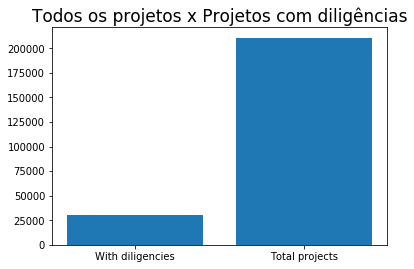

In [423]:
import matplotlib.pyplot as plt
from utils.plotter import Plotter

dd = {'With diligencies':projects_with_diligencies,
      'Total projects': total_projects}
plt.bar(dd.keys(), dd.values())
plt.title('Todos os projetos x Projetos com diligências', size=17)
plt.show()

**Tipos distintos de diligência**

In [424]:
display(dt_diligencias['idTipoDiligencia'].unique())

array([124, 126, 181, 183, 171, 563, 564, 172, 180, 179, 174, 627])

### Adicionando data do projeto na tabela de diligências

In [425]:
dt_projetos = dt_projetos.set_index('IdPRONAC')
dt_diligencias = dt_diligencias.join(dt_projetos, on = ['idPronac'])
dt_diligencias.head()

,idDiligencia,idPronac,idTipoDiligencia,DtSolicitacao,idSolicitante,DtResposta,idProponente,stEnviado,Area,Segmento,DtProtocolo
0,1,115502,124,2009-09-24 16:52:23,2851,2010-01-18 14:39:07,NaN,S,1,11,2009-08-06 16:27:50
1,2,114250,124,2009-09-24 18:11:00,2825,2009-10-07 19:45:18,6010.0,S,3,31,2009-06-29 15:22:16
2,3,115134,124,2009-09-24 18:13:00,2825,2009-10-07 16:10:21,9553.0,S,1,11,2009-07-27 15:44:16
3,4,114399,124,2009-09-24 18:26:00,2845,2009-10-06 09:30:35,9521.0,S,3,32,2009-07-02 15:15:34
4,5,115059,124,2009-09-24 18:35:00,2915,2009-10-02 18:01:47,11598.0,S,3,33,2009-07-23 11:43:45


# Limpando os dados

É conhecido que dados muito antigos (de 1992, por exemplo) podem ser inconsistentes, então vamos filtrar os dados a partir de uma data de início (2013).

In [426]:
from datetime import datetime

START_DATE = datetime(day=1, month=1, year=2013)

dt_projetos = dt_projetos[dt_projetos.loc[:, date_column] >= START_DATE]
dt_diligencias = dt_diligencias[dt_diligencias.loc[:, date_column] >= START_DATE]

## Repetindo o histograma de projetos com pelo menos uma diligência, a partir de 2013

52495


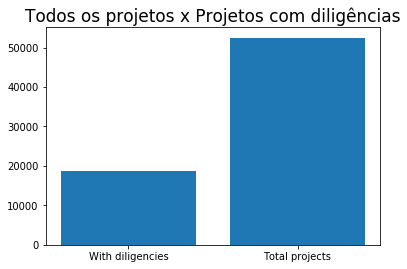

In [427]:
total_projects = len(dt_projetos)
projects_with_diligencies = len(dt_diligencias['idPronac'].unique())
print(total_projects)

dd = {'With diligencies':projects_with_diligencies,
      'Total projects': total_projects}
plt.bar(dd.keys(), dd.values())
plt.title('Todos os projetos x Projetos com diligências', size=17)
plt.show()

## Quantidade média de diligências por projetos entre projetos com pelo menos uma diligência

In [428]:
from scipy import stats

unique, counts = np.unique(dt_diligencias.idPronac.values, return_counts=True)
pd.DataFrame(counts).describe()

,0
count,18642.000000
mean,2.160873
std,1.815752
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,40.000000


## Quantidade média de diligências por projetos entre todos os projetos

In [429]:
pronacs, diligencies = np.unique(dt_diligencias.idPronac.values, return_counts=True)
diligencies_per_project = np.append(diligencies, np.zeros(len(dt_projetos) - len(pronacs), dtype=np.int64))

pd.DataFrame(diligencies_per_project).describe()

,0
count,52495.000000
mean,0.767368
std,1.496705
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,40.000000


### Histograma de quantidade de diligência por projetos entre todos os projetos

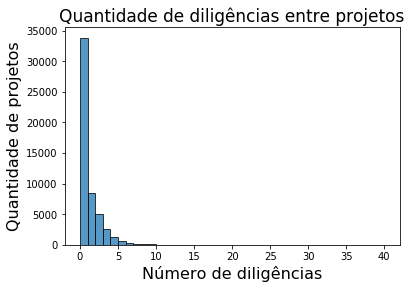

In [430]:
plt.hist(diligencies_per_project, edgecolor = 'black', alpha = 0.75, bins = list(set(diligencies_per_project)))
plt.xlabel('Número de diligências', size=16)
plt.ylabel('Quantidade de projetos', size=16)
plt.title('Quantidade de diligências entre projetos', size=17)
plt.show()

### Histograma de quantidade de diligência por projetos entre projetos com pelo menos uma diligência

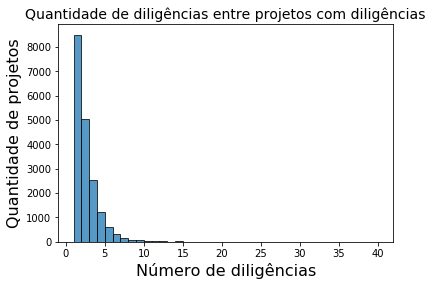

In [431]:
plt.hist(diligencies, edgecolor = 'black', alpha = 0.75, bins = list(set(diligencies)))
plt.xlabel('Número de diligências', size=16)
plt.ylabel('Quantidade de projetos', size=16)
plt.title('Quantidade de diligências entre projetos com diligências', size=14)
plt.show()

## Tempo médio de resposta de uma diligência

**Convertendo datas para datetime**

In [432]:
dt_diligencias['DtSolicitacao'] = pd.to_datetime(dt_diligencias['DtSolicitacao'], format = Dates.DATE_INPUT_FORMAT)
dt_diligencias['DtResposta'] = pd.to_datetime(dt_diligencias['DtResposta'], format = Dates.DATE_INPUT_FORMAT)

dt_diligencias.head()

,idDiligencia,idPronac,idTipoDiligencia,DtSolicitacao,idSolicitante,DtResposta,idProponente,stEnviado,Area,Segmento,DtProtocolo
14899,15189,159395,124,2013-01-08 10:17:00,2150,2013-01-18 09:34:14,81288.0,S,6,6C,2013-01-07 14:58:42
14900,15190,159405,124,2013-01-08 11:23:00,2151,2013-01-22 14:57:29,1025.0,S,6,6E,2013-01-07 15:34:44
14904,15194,159375,124,2013-01-08 22:03:00,3979,2013-01-15 18:20:04,22139.0,S,3,32,2013-01-03 14:17:59
14916,15206,159482,124,2013-01-10 13:34:00,3888,2013-01-10 16:22:40,716.0,S,6,6E,2013-01-09 15:23:31
14918,15208,159375,124,2013-01-10 15:35:00,3979,2013-01-15 18:20:29,22139.0,S,3,32,2013-01-03 14:17:59


### Tempo médio de resposta de uma diligencia, considerando todas as diligências do banco

In [433]:
solicitation_date = dt_diligencias.DtSolicitacao.values
reply_date = dt_diligencias.DtResposta.values

answer_time = reply_date - solicitation_date
diff_time = [diff.astype('timedelta64[D]') for diff in answer_time]
pd.DataFrame(diff_time).describe()

,0
count,39992
mean,9 days 14:10:16.443288
std,13 days 03:51:35.851692
min,-73 days +00:00:00
25%,0 days 00:00:00
50%,4 days 00:00:00
75%,14 days 00:00:00
max,490 days 00:00:00


### Tempo médio de resposta de uma diligencia, considerando apenas diligencias com data de resposta maior que data de solicitação

In [434]:
solicitation_bigger_then_reply = dt_diligencias['DtSolicitacao'] < dt_diligencias['DtResposta']

solicitation_date = dt_diligencias[solicitation_bigger_then_reply].DtSolicitacao.values
reply_date = dt_diligencias[solicitation_bigger_then_reply].DtResposta.values

answer_time = reply_date - solicitation_date
diff_time = [diff.astype('timedelta64[D]') for diff in answer_time]
pd.DataFrame(diff_time).describe()

,0
count,39911
mean,9 days 15:08:51.733106
std,13 days 02:49:34.705979
min,0 days 00:00:00
25%,0 days 00:00:00
50%,4 days 00:00:00
75%,14 days 00:00:00
max,490 days 00:00:00


## Importando os dados de Segmento e Area dos projetos

### Area

In [435]:
area_file_name = 'area.csv'
area_file_path = os.path.join(data_folder, area_file_name)
dt_area = pd.read_csv(area_file_path, low_memory=False)
display(dt_area)

,Codigo,Descricao,stEstado
0,1,Artes Cênicas,1
1,2,Audiovisual,1
2,3,Música,1
3,4,Artes Visuais,1
4,5,Patrimônio Cultural,1
5,6,Humanidades,1
6,7,Artes Integradas,0
7,9,Museus e Memória,1


### Segmento

In [436]:
segmento_file_name = 'segmento.csv'
segmento_file_path = os.path.join(data_folder, segmento_file_name)
dt_segmento = pd.read_csv(segmento_file_path, usecols = ['Codigo', 'Descricao'], low_memory=False)
dt_segmento.head()

,Codigo,Descricao
0,11,Teatro
1,12,Dança
2,13,Circo
3,14,Ópera
4,15,Mímica
